## Problem definition

In [1]:
# ---------------------------------------------------------------------------*/
# - import necessary python packages

import numpy as np
from matplotlib import pyplot as plt

import notebook_utilities as nbutils
tf = nbutils.import_tensorflow()

import utilities as utils
import function as fun

### Dynamical system

In [2]:
# ---------------------------------------------------------------------------*/
# - put prior, analytical, knowledge into code

def osc_true(d: tf.Tensor, w0: tf.Tensor, t: tf.Tensor) -> tf.Tensor:
    """Compute an analytical solution to an under-damped harmonic oscillator problem."""
    assert d < w0
    w = tf.sqrt(w0**2-d**2)
    phi = tf.math.atan(-d/w)
    A = 1/(2*tf.cos(phi))
    cos = tf.cos(phi+w*t)
    exp = tf.exp(-d*t)
    u = exp*2*A*cos
    return u

# specify true parameters of a harmonic oscillator
d, w0 = tf.constant(2.), tf.constant(20.)
mu, k = 2*d, w0**2

In [3]:
# ---------------------------------------------------------------------------*/
# - configure data

# preset the random number generator to get reproducible results
utils.preset_rng_tf(1024)

# specify frequency setpoint data
w0_epochs = 5000
w0_setpoints = tf.reshape(tf.constant([20, 10, 15, 20], dtype=float), shape=(-1, 1))
w0_setpoints_n = tf.size(w0_setpoints)
w0_data_i = tf.repeat(w0_setpoints, repeats=w0_epochs + 1, axis=0)
w0_data_o = np.zeros_like(w0_data_i)

# specify number of points
test_n = 300
phys_n = 30
meas_n = 40

# prepare time points
t_test = tf.reshape(tf.linspace(0., 1., test_n), shape=(-1, 1)) # testing
t_phys = tf.reshape(tf.linspace(0., 1., phys_n),  shape=(-1, 1)) # check physics
t_meas = tf.random.uniform(shape=[meas_n, 1]) # observation

## Online learning

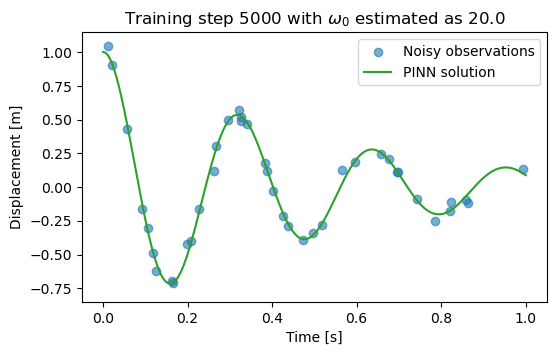

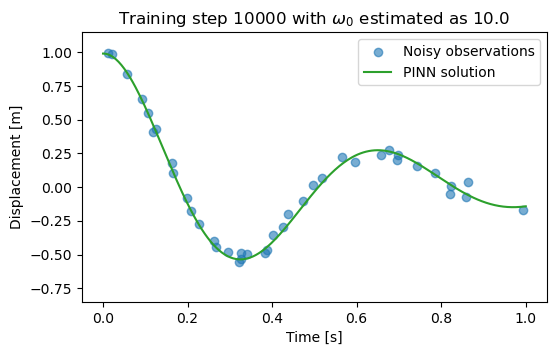

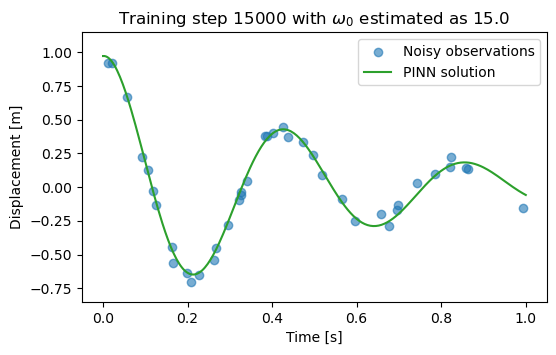

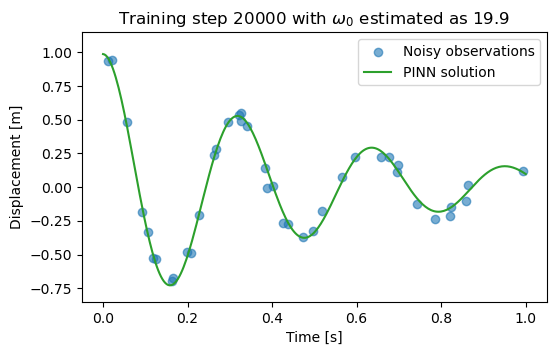

In [4]:
# ---------------------------------------------------------------------------*/
# - online learning

# load a trained neural network
osc = tf.keras.models.load_model('data/pinn_play_ident.keras')

# hyperparameters for loss functions
hp_phys = 1e0
hp_data = 1e4

# learning rate
lr = 0.024

# instantiate an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=lr)

# train the neural network using a manual loop
epochs = w0_setpoints_n * w0_epochs
for epoch in range(epochs + 1):

    # measure true oscillator response perturbed by noise
    u_meas = osc_true(d, w0_data_i[epoch], t_meas) + 0.04*tf.random.normal(tf.shape(t_meas))

    with tf.GradientTape() as tape:
        tape.watch(k)

        # compute physics loss
        with tf.GradientTape() as tape_phys:
            tape_phys.watch(t_phys)
            with tf.GradientTape() as tape2_phys:
                tape2_phys.watch(t_phys)
                u = osc(t_phys)
            dudt = tape2_phys.gradient(u, t_phys)
        d2udt2 = tape_phys.gradient(dudt, t_phys)
        loss_phys = tf.reduce_mean((d2udt2 + mu*dudt + k*u)**2)

        # compute data loss
        u = osc(t_meas)
        loss_data = tf.reduce_mean((u - u_meas)**2)

        # combine losses together
        loss = hp_phys * loss_phys + hp_data * loss_data

    # compute gradients
    [params_grad, k_grad] = tape.gradient(loss, [osc.trainable_variables, k])

    # apply gradients;
    # gradient for the identified parameter is applied manually here
    k = k - lr*k_grad
    opt.apply_gradients(zip(params_grad, osc.trainable_variables))

    # save k values for later statistics
    this_w0 = tf.sqrt(k).numpy()
    w0_data_o[epoch] = this_w0

    # plot results as the training progresses
    if epoch is not 0 and epoch % w0_epochs == 0:
        u = osc(t_test)
        plt.figure(figsize=(6, 3.5))
        plt.title(f"Training step {epoch} with $\omega_0$ estimated as {this_w0:.1f}")
        plt.scatter(t_meas[:, 0], u_meas[:, 0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.xlabel('Time [s]')
        plt.ylabel('Displacement [m]')
        plt.ylim([-0.85, 1.15])
        plt.legend()
        plt.savefig(f'fig/pinn_play_online_step_{epoch}.svg')
        plt.show()

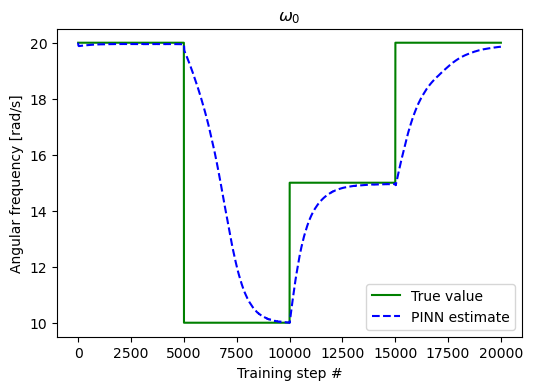

In [5]:
# ---------------------------------------------------------------------------*/
# - check identified parameters

plt.figure(figsize=(6, 4))
plt.title("$\omega_0$")
plt.plot(w0_data_i[:w0_epochs*w0_setpoints_n], label='True value', color='green')
plt.plot(w0_data_o[:w0_epochs*w0_setpoints_n], label='PINN estimate', color='blue', linestyle='dashed')
plt.legend()
plt.xlabel('Training step #')
plt.ylabel('Angular frequency [rad/s]')
plt.savefig('fig/pinn_play_online_track.svg')
plt.show()